# Cavity MD Simulation Notebook

This notebook runs a cavity molecular dynamics simulation with Bussi thermostat for molecules, Langevin thermostat for the cavity, and all tracking features enabled.

## Setup and Imports

In [1]:
import hoomd
import numpy as np
from numba import njit
from hoomd.bussi_reservoir.thermostats import BussiReservoir as Bussi
import time
from pathlib import Path
import datetime

# Import the CavityForce from the installed plugin
from hoomd.cavitymd import CavityForce

# Import analysis and tracking classes from the plugin
from hoomd.cavitymd import (
    CavityForce, PhysicalConstants, Status, ElapsedTimeTracker,
    TimestepFormatter, AdaptiveTimestepUpdater, FieldAutocorrelationTracker,
    CavityModeTracker, EnergyTracker
)

print("All imports successful!")

All imports successful!


## Configuration Parameters

In [2]:
# Simulation parameters
temperature = 100.0  # K
runtime_ps = 500.0   # ps
coupling_strength = 1e-3
cavity_frequency = 2000.0  # cm^-1
replica = 1
frame = -1  # Use last frame
finite_q = False

# Thermostat settings
molecular_thermostat = 'bussi'
cavity_thermostat = 'langevin'
molecular_thermostat_tau = 5.0  # ps
cavity_thermostat_tau = 5.0     # ps
cavity_damping_factor = 1.0

# Output periods (ps)
energy_output_period_ps = 0.1
fkt_output_period_ps = 1.0
gsd_output_period_ps = 50.0
console_output_period_ps = 1.0

# Enable all trackers
enable_fkt = True
enable_energy_tracking = True
fkt_kmag = 1.0
fkt_num_wavevectors = 50
fkt_reference_interval_ps = 1.0
fkt_max_references = 10

# Device settings
device = 'CPU'  # Change to 'GPU' if desired
gpu_id = 0

# Fixed vs adaptive timestep
error_tolerance = 1.0  # >0 for adaptive, 0 for fixed
dt_fs = 1.0  # Only used if error_tolerance = 0

# File settings
input_gsd = '../init-0.gsd'  # Update this path as needed
output_prefix = f'prod-{replica}'

print(f"Configuration set:")
print(f"  Temperature: {temperature} K")
print(f"  Runtime: {runtime_ps} ps")
print(f"  Molecular thermostat: {molecular_thermostat}")
print(f"  Cavity thermostat: {cavity_thermostat}")
print(f"  Coupling strength: {coupling_strength}")
print(f"  All trackers enabled: F(k,t), Energy, Performance")

Configuration set:
  Temperature: 100.0 K
  Runtime: 500.0 ps
  Molecular thermostat: bussi
  Cavity thermostat: langevin
  Coupling strength: 0.001
  All trackers enabled: F(k,t), Energy, Performance


## Helper Functions

In [3]:
def unwrap_positions(positions, images, box_lengths):
    """Unwrap particle positions across periodic boundaries."""
    pos = np.asarray(positions)
    img = np.asarray(images)
    box = np.asarray(box_lengths)
    return pos + img * box[None, :]

class PerformanceTracker(hoomd.custom.Action):
    """Custom performance tracker to display ns/day and other metrics."""
    
    def __init__(self, simulation, runtime_ps, time_tracker=None):
        super().__init__()
        self.sim = simulation
        self.runtime_ps = runtime_ps
        self.time_tracker = time_tracker
        self.start_time = time.time()
        self.last_timestep = 0
        self.current_ns_per_day = 0.0
        self.current_eta = ""
        
    def act(self, timestep):
        if timestep <= 1:
            return
            
        # Calculate simulation progress
        if self.time_tracker is not None:
            simulation_time_ps = self.time_tracker.elapsed_time
        else:
            dt = float(self.sim.operations.integrator.dt)
            simulation_time_ps = PhysicalConstants.atomic_units_to_ps(dt * timestep)
        
        # Calculate wall time elapsed
        wall_time_elapsed = time.time() - self.start_time
        
        if wall_time_elapsed > 0:
            # Calculate ns/day
            ps_per_second = simulation_time_ps / wall_time_elapsed
            ns_per_second = ps_per_second / 1000.0
            self.current_ns_per_day = ns_per_second * 86400
            
            # Calculate ETA
            if simulation_time_ps > 0:
                total_wall_time_needed = (self.runtime_ps / simulation_time_ps) * wall_time_elapsed
                seconds_remaining = total_wall_time_needed - wall_time_elapsed
                if seconds_remaining > 0:
                    eta_td = datetime.timedelta(seconds=int(seconds_remaining))
                    self.current_eta = str(eta_td)
                else:
                    self.current_eta = "00:00:00"
            else:
                self.current_eta = "calculating..."
        
    @hoomd.logging.log
    def ns_per_day(self):
        return f"{self.current_ns_per_day:.2f}"
    
    @hoomd.logging.log
    def eta_remaining(self):
        return self.current_eta

def create_cavity_particle(snapshot, coupling_str, freq, finite_q, temperature):
    """Add a cavity particle to the simulation snapshot."""
    print("Adding cavity particle to system...")
    
    # Calculate dipole moment and photon position
    positions = unwrap_positions(snapshot.particles.position, snapshot.particles.image, 
                               snapshot.configuration.box[:3])
    dipmom = np.einsum('i,ij->j', snapshot.particles.charge, positions)

    omegac = freq / PhysicalConstants.HARTREE_TO_CM_MINUS1
    kB = PhysicalConstants.KB_HARTREE_PER_K
    
    if finite_q:
        # Allow finite-q photon displacement based on dipole-coupling interaction
        newpos = -dipmom * coupling_str / omegac**2
        newpos[-1] = 0.0
        # Only add thermal fluctuations if coupling is non-zero
        if coupling_str != 0.0:
            sigma = np.sqrt(kB * temperature / omegac**2)
            newpos = np.random.normal(loc=newpos, scale=sigma, size=3)
            print(f"Finite-q mode: Photon displaced by dipole interaction to {newpos} (with thermal fluctuations)")
        else:
            print(f"Finite-q mode: Photon at equilibrium position {newpos} (no thermal fluctuations due to zero coupling)")
    else:
        # Start photon at origin (q=0 limit)
        newpos = np.array([0.0, 0.0, 0.0])
        # Only add thermal fluctuations if coupling is non-zero
        if coupling_str != 0.0:
            sigma = np.sqrt(kB * temperature / omegac**2)
            newpos = np.random.normal(loc=newpos, scale=sigma, size=3)
            print("q=0 mode: Photon positioned at origin + thermal fluctuations")
        else:
            print("q=0 mode: Photon positioned exactly at origin (no thermal fluctuations due to zero coupling)")
    
    # Wrap position and get image flags
    def wrap_position(x, L):
        image_flags = np.floor((x + L/2) / L)
        wrapped_position = x - image_flags * L
        return wrapped_position, image_flags.astype(int)
        
    newpos, image_flags = wrap_position(newpos, np.array(snapshot.configuration.box[:3]))
    
    # Add photon particle
    if 'L' not in snapshot.particles.types:
        snapshot.particles.types.append('L')
    snapshot.particles.N += 1
    snapshot.particles.typeid = np.append(snapshot.particles.typeid, [2])
    snapshot.particles.position = np.append(snapshot.particles.position, [newpos], axis=0)
    snapshot.particles.charge = np.append(snapshot.particles.charge, [0.0])
    snapshot.particles.mass = np.append(snapshot.particles.mass, [1.0])
    snapshot.particles.diameter = np.append(snapshot.particles.diameter, [1.0])
    snapshot.particles.image = np.vstack([snapshot.particles.image, image_flags])

    # Set additional particle properties for the photon
    if hasattr(snapshot.particles, "body"):
        snapshot.particles.body = np.append(snapshot.particles.body, [-1], axis=0)

    if hasattr(snapshot.particles, "orientation"):
        snapshot.particles.orientation = np.append(
            snapshot.particles.orientation,
            [[1.0, 0.0, 0.0, 0.0]],
            axis=0
        )

    if hasattr(snapshot.particles, "moment_inertia"):
        snapshot.particles.moment_inertia = np.vstack([
            snapshot.particles.moment_inertia,
            np.zeros((1, 3))
        ])

    if hasattr(snapshot.particles, "velocity"):
        snapshot.particles.velocity = np.vstack([
            snapshot.particles.velocity,
            np.zeros((1, 3))
        ])

    if hasattr(snapshot.particles, "angmom"):
        snapshot.particles.angmom = np.vstack([
            snapshot.particles.angmom,
            np.zeros((1, 4))
        ])
        
    print(f"Cavity particle added at position {newpos}")
    return snapshot

print("Helper functions defined!")

Helper functions defined!


## Physical Parameter Calculations

In [4]:
# Physical constants
kB = PhysicalConstants.KB_HARTREE_PER_K

# Time stepping parameters
dt_ps = 0.0001  # timestep in ps (0.1 fs)
runtime_real = runtime_ps  # runtime in ps

# Calculate different output periods in timesteps
energy_period = max(1, int(energy_output_period_ps / dt_ps))
fkt_period = max(1, int(fkt_output_period_ps / dt_ps))
gsd_period = max(1, int(gsd_output_period_ps / dt_ps))
console_period = max(1, int(console_output_period_ps / dt_ps))

# Convert timestep from ps to atomic units
dt_au = PhysicalConstants.ps_to_atomic_units(dt_ps)

# Calculate total steps needed for the specified runtime
total_steps_needed = int(runtime_real / dt_ps)

print(f"Time conversions:")
print(f"  Timestep: {dt_ps} ps = {dt_au:.6f} a.u.")
print(f"  Runtime: {runtime_ps:.1f} ps = {total_steps_needed} steps")
print(f"  Steps per ps: {1.0/dt_ps:.1f}")
print(f"Output periods (steps):")
print(f"  Energy: {energy_period} ({energy_output_period_ps:.3f} ps)")
print(f"  F(k,t): {fkt_period} ({fkt_output_period_ps:.3f} ps)")
print(f"  GSD: {gsd_period} ({gsd_output_period_ps:.3f} ps)")
print(f"  Console: {console_period} ({console_output_period_ps:.3f} ps)")

Time conversions:
  Timestep: 0.0001 ps = 4.134138 a.u.
  Runtime: 500.0 ps = 5000000 steps
  Steps per ps: 10000.0
Output periods (steps):
  Energy: 1000 (0.100 ps)
  F(k,t): 10000 (1.000 ps)
  GSD: 500000 (50.000 ps)
  Console: 10000 (1.000 ps)


## Device Setup and Simulation Initialization

In [5]:
# Setup device
if device == 'GPU':
    try:
        try:
            device_obj = hoomd.device.GPU(gpu_ids=[gpu_id])
        except TypeError:
            device_obj = hoomd.device.GPU(gpu_id=gpu_id)
        print(f"Initializing simulation on GPU {gpu_id}")
    except Exception as e:
        print(f"Failed to initialize GPU {gpu_id}: {str(e)}")
        print("Falling back to CPU")
        device_obj = hoomd.device.CPU()
        device = 'CPU'
elif device == 'CPU':
    device_obj = hoomd.device.CPU()
    print("Initializing simulation on CPU")

# Create simulation object
sim = hoomd.Simulation(device=device_obj, seed=np.random.randint(int(10**4)))

print("Simulation object created!")

Initializing simulation on CPU
Simulation object created!


## Load GSD File and Add Cavity Particle

In [6]:
import gsd.hoomd

# Load GSD file and handle cavity particle
with gsd.hoomd.open(input_gsd, 'r') as f:
    if frame < 0:
        frame = len(f) + frame  # Convert negative index to positive
        if frame < 0:  # Handle case where abs(frame) > len(f)
            frame = 0
    snapshot = f[frame]
    
    # Add cavity particle
    snapshot = create_cavity_particle(snapshot, coupling_strength, cavity_frequency, finite_q, temperature)
    sim.create_state_from_snapshot(snapshot)
    print(f"Simulation state created from modified snapshot with cavity particle")

print(f"Loaded frame {frame} from {input_gsd}")
print(f"System now has {sim.state.N_particles} particles")

Adding cavity particle to system...
Adding cavity particle to system...
q=0 mode: Photon positioned at origin + thermal fluctuations
Cavity particle added at position [-1.45764596  1.18903136 -3.24708182]
Simulation state created from modified snapshot with cavity particle
Loaded frame 499 from ../init-0.gsd
System now has 501 particles


## Setup Forces

In [7]:
forces = []

# Setup cavity force
omegac = cavity_frequency / PhysicalConstants.HARTREE_TO_CM_MINUS1
cavityforce = CavityForce(kvector=np.array([0,0,1]), couplstr=coupling_strength, omegac=omegac)
forces.append(cavityforce)
print(f"Cavity force added: omega_c = {omegac:.6f} a.u., coupling = {coupling_strength}")

# Setup harmonic bonds
harmonic = hoomd.md.bond.Harmonic()
harmonic.params['O-O'] = dict(k=2*0.36602, r0=2.281655158)
harmonic.params['N-N'] = dict(k=2*0.71625, r0=2.0743522177)
forces.append(harmonic)
print("Harmonic bond forces added")

# Setup neighbor list
rcut = 15
cell = hoomd.md.nlist.Cell(buffer=1.0, exclusions=('bond',))

# Setup Lennard-Jones interactions
lj = hoomd.md.pair.LJ(nlist=cell, mode='shift')
lj.params[('O', 'O')] = dict(epsilon=0.00016685201, sigma=6.230426584)
lj.r_cut[('O', 'O')] = rcut
lj.params[('N', 'N')] = dict(epsilon=0.000083426, sigma=5.48277488)
lj.r_cut[('N', 'N')] = rcut
lj.params[('N', 'O')] = dict(epsilon=0.00025027802, sigma=4.9832074319)
lj.r_cut[('N', 'O')] = rcut

# Disable pair interaction with 'L' particle (photon)
lj.params[('L', 'N')] = dict(epsilon=0.0, sigma=1.0)
lj.r_cut[('L', 'N')] = 0.0
lj.params[('N', 'L')] = dict(epsilon=0.0, sigma=1.0)
lj.r_cut[('N', 'L')] = 0.0
lj.params[('O', 'L')] = dict(epsilon=0.0, sigma=1.0)
lj.r_cut[('O', 'L')] = 0.0
lj.params[('L', 'O')] = dict(epsilon=0.0, sigma=1.0)
lj.r_cut[('L', 'O')] = 0.0
lj.params[('L', 'L')] = dict(epsilon=0.0, sigma=1.0)
lj.r_cut[('L', 'L')] = 0.0
forces.append(lj)
print("Lennard-Jones forces added")

# Setup long-range Coulomb interactions using PPPM method
numpoints = 32
order = 6
short, long = hoomd.md.long_range.pppm.make_pppm_coulomb_forces(
    nlist=cell, resolution=[numpoints, numpoints, numpoints], 
    order=order, r_cut=rcut, alpha=0.0
)
forces.append(short)
forces.append(long)
print("PPPM Coulomb forces added")

print(f"Total forces: {len(forces)}")

CavityForce initialized using cpp implementation
Cavity force added: omega_c = 0.009113 a.u., coupling = 0.001
Harmonic bond forces added
Lennard-Jones forces added
PPPM Coulomb forces added
Total forces: 5


## Setup Thermostats

In [8]:
kT = kB * temperature
molecular_filter = hoomd.filter.Type(['O', 'N'])  # Molecular particles only
cavity_filter = hoomd.filter.Type(['L'])  # Cavity particle only

# Convert thermostat time constants from ps to atomic units
molecular_tau_au = PhysicalConstants.ps_to_atomic_units(molecular_thermostat_tau)
cavity_tau_au = PhysicalConstants.ps_to_atomic_units(cavity_thermostat_tau)

print(f"Thermostat time constant conversions:")
print(f"  Molecular: {molecular_thermostat_tau:.3f} ps = {molecular_tau_au:.6f} a.u.")
print(f"  Cavity: {cavity_thermostat_tau:.3f} ps = {cavity_tau_au:.6f} a.u.")

# Configure molecular thermostat (Bussi)
print("Setting up molecular Bussi thermostat...")
molecular_bussi = Bussi(kT=kT, tau=molecular_tau_au)
molecular_method = hoomd.md.methods.ConstantVolume(filter=molecular_filter, thermostat=molecular_bussi)
print(f"Molecular Bussi thermostat configured: T = {temperature:.1f} K, kT = {kT:.6f} a.u., tau = {molecular_thermostat_tau:.3f} ps")

# Configure cavity thermostat (Langevin)
print("Setting up cavity Langevin thermostat...")
base_gamma = PhysicalConstants.gamma_from_tau_ps(cavity_thermostat_tau)
cavity_gamma = cavity_damping_factor * base_gamma
cavity_method = hoomd.md.methods.Langevin(filter=cavity_filter, 
                                         kT=kT, default_gamma=cavity_gamma, tally_reservoir_energy=True)
print(f"Cavity Langevin thermostat configured: T = {temperature:.1f} K, kT = {kT:.6f} a.u.")
print(f"  base_gamma = {base_gamma:.6f} a.u.^-1 (tau = {cavity_thermostat_tau:.3f} ps)")
print(f"  effective_gamma = {cavity_gamma:.6f} a.u.^-1 (damping_factor = {cavity_damping_factor:.1f}x)")

print("Thermostats configured!")

Thermostat time constant conversions:
  Molecular: 5.000 ps = 206706.894584 a.u.
  Cavity: 5.000 ps = 206706.894584 a.u.
Setting up molecular Bussi thermostat...
Molecular Bussi thermostat configured: T = 100.0 K, kT = 0.000317 a.u., tau = 5.000 ps
Setting up cavity Langevin thermostat...
Cavity Langevin thermostat configured: T = 100.0 K, kT = 0.000317 a.u.
  base_gamma = 0.000005 a.u.^-1 (tau = 5.000 ps)
  effective_gamma = 0.000005 a.u.^-1 (damping_factor = 1.0x)
Thermostats configured!


## Setup Integrator

In [9]:
# Setup integrator with initial dt
integrator = hoomd.md.Integrator(dt=dt_au, forces=forces)
sim.operations.integrator = integrator

# Set integration methods
valid_methods = [molecular_method, cavity_method]
sim.operations.integrator.methods = valid_methods

print(f"Integrator configured with initial dt = {dt_au:.6f} a.u. ({dt_ps:.6f} ps)")
print(f"Number of integration methods: {len(valid_methods)}")

Integrator configured with initial dt = 4.134138 a.u. (0.000100 ps)
Number of integration methods: 2


## Thermalize System

In [10]:
# Thermalize particle momenta - only molecular particles
sim.state.thermalize_particle_momenta(kT=kT, filter=molecular_filter)
print("Thermalized molecular particles only (cavity particle excluded)")

# Initialize cavity particle velocity
with sim.state.cpu_local_snapshot as snap:
    cavity_indices = np.where(snap.particles.typeid == 2)[0]
    if len(cavity_indices) > 0:
        cavity_idx = cavity_indices[0]  # Get first cavity particle
        
        # For 3D Maxwell-Boltzmann: each component has variance kT/m
        # With mass = 1.0 a.u., std dev per component = sqrt(kT)
        cavity_velocity = np.random.normal(0.0, np.sqrt(kT), size=3)
        
        # Calculate expected kinetic energy and temperature
        expected_ke = 0.5 * 1.0 * np.sum(cavity_velocity**2)  # KE = (1/2) * m * v²
        expected_temp = (2.0/3.0) * expected_ke / kB  # T = (2/3) * KE / kB for 3D

        print(f"Cavity particle thermalization:")
        print(f"  Target temperature: {temperature:.1f} K")
        print(f"  kT = {kT:.6f} a.u.")
        print(f"  Initial velocity: {cavity_velocity}")
        print(f"  Initial KE: {expected_ke:.6f} a.u.")
        print(f"  Expected temperature: {expected_temp:.1f} K")
        
        snap.particles.velocity[cavity_idx] = cavity_velocity
    else:
        print("WARNING: No cavity particle found for thermalization!")

# Initialize reservoir energy logging (requires at least one simulation step)
print("Initializing reservoir energy tracking...")
sim.run(1)
print("System thermalized!")

Thermalized molecular particles only (cavity particle excluded)
Cavity particle thermalization:
  Target temperature: 100.0 K
  kT = 0.000317 a.u.
  Initial velocity: [-0.0153637  -0.01243041 -0.00205512]
  Initial KE: 0.000197 a.u.
  Expected temperature: 41.6 K
Initializing reservoir energy tracking...
CPU CavityForceCompute initialized successfully
notice(2): charge.pppm: RMS error: 2.31675e-08
CavityForceCompute initialized: omegac=0.00911267 a.u., couplstr=0.001 a.u., K=8.30408e-05 a.u.
System thermalized!


## Compute Optimal Timestep

In [11]:
if error_tolerance > 0:
    print("Computing optimal timestep...")
    
    # Run one step to initialize forces
    sim.run(1)
    
    # Use initial error tolerance
    initial_error_tolerance = error_tolerance * 1e-3
    
    # Collect forces and masses
    particle_data = sim.state.get_snapshot().particles
    masses = np.array(particle_data.mass)
    n_particles = len(masses)
    
    # Initialize total forces array
    total_forces = np.zeros((n_particles, 3))
    
    # Sum forces from all force objects
    for force in sim.operations.integrator.forces:
        try:
            particle_forces = force.forces
            if particle_forces is not None and len(particle_forces) == n_particles:
                total_forces += np.asarray(particle_forces)
        except (AttributeError, RuntimeError) as e:
            continue
    
    # Calculate sum |f_i| / m_i
    force_norm = np.array([np.linalg.norm(f) for f in total_forces])
    force_mass_sum = np.sum(force_norm / masses)
    
    # Update timestep using current error tolerance
    if force_mass_sum > 0:
        optimal_dt = np.sqrt(initial_error_tolerance / force_mass_sum)
        
        # Update integrator timestep
        sim.operations.integrator.dt = optimal_dt
        dt_au = optimal_dt  # Update stored dt
        
        print(f"Optimal timestep computed and set:")
        print(f"  Initial error tolerance: {initial_error_tolerance:.2e}")
        print(f"  Force/mass sum: {force_mass_sum:.6e}")
        print(f"  Optimal dt: {optimal_dt:.6f} a.u. ({PhysicalConstants.atomic_units_to_ps(optimal_dt) * 1000:.3f} fs)")
    else:
        print("WARNING: Force/mass sum is zero - keeping initial timestep")
else:
    if dt_fs is not None:
        # Use user-specified timestep
        dt_au = PhysicalConstants.ps_to_atomic_units(dt_fs / 1000.0)
        sim.operations.integrator.dt = dt_au
        print(f"Using user-specified fixed timestep: {dt_au:.6f} a.u. ({dt_fs:.3f} fs)")
    else:
        print(f"Using default fixed timestep: {sim.operations.integrator.dt:.6f} a.u.")

Computing optimal timestep...
Optimal timestep computed and set:
  Initial error tolerance: 1.00e-03
  Force/mass sum: 5.161888e-04
  Optimal dt: 1.391860 a.u. (0.034 fs)


## Setup Trackers and Loggers

In [12]:
# Create elapsed time tracker
time_tracker = ElapsedTimeTracker(sim, runtime_ps)
sim.operations.updaters.append(hoomd.update.CustomUpdater(
    action=time_tracker, trigger=hoomd.trigger.Periodic(1)
))

# Create custom performance tracker
performance_tracker = PerformanceTracker(sim, runtime_ps, time_tracker)
sim.operations.updaters.append(hoomd.update.CustomUpdater(
    action=performance_tracker, trigger=hoomd.trigger.Periodic(100)
))

# Set up adaptive timestep updater if error_tolerance is positive
adaptive_action = None
if error_tolerance > 0:
    print(f"Setting up adaptive timestep updater (error_tolerance = {error_tolerance})")
    adaptive_action = AdaptiveTimestepUpdater(
        state=sim.state,
        integrator=sim.operations.integrator,
        error_tolerance=error_tolerance,
        time_constant_ps=50.0,
        initial_fraction=1e-4,
        adaptiveerror=True,
        cavity_damping_factor=cavity_damping_factor,
        molecular_thermostat_tau=molecular_thermostat_tau,
        cavity_thermostat_tau=cavity_thermostat_tau,
        time_tracker=time_tracker
    )
    
    adaptive_updater = hoomd.update.CustomUpdater(
        action=adaptive_action,
        trigger=hoomd.trigger.Periodic(energy_period)
    )
    sim.operations.updaters.append(adaptive_updater)
    print("Adaptive timestep updater enabled")
else:
    print("Fixed timestep mode (error_tolerance = 0)")

# Create status tracker and timestep formatter
status = Status(sim, runtime_ps, time_tracker)
timestep_formatter = TimestepFormatter(sim.operations.integrator)

print("Basic trackers setup complete!")

Setting up adaptive timestep updater (error_tolerance = 1.0)
Performing error tolerance ramping with time constant 50.0 ps
Adaptive timestep updater enabled
Basic trackers setup complete!


## Setup Comprehensive Logging

In [13]:
# Create comprehensive logger
logger = hoomd.logging.Logger(categories=['scalar', 'string'])

# Basic simulation quantities
logger.add(sim, quantities=['timestep', 'tps'])

# Time and performance information
logger[('Time', 'elapsed_ps')] = (time_tracker, 'elapsed_time', 'scalar')
logger[('Performance', 'ns_per_day')] = (performance_tracker, 'ns_per_day', 'string')
logger[('Performance', 'eta')] = (performance_tracker, 'eta_remaining', 'string')
logger[('Timestep', 'dt_fs')] = (timestep_formatter, 'dt_fs', 'scalar')

# Add adaptive timestep logging if enabled
if adaptive_action is not None:
    logger[('Adaptive', 'error_tolerance')] = (adaptive_action, 'error_tolerance', 'scalar')
    logger[('Adaptive', 'elapsed_time_ps')] = (adaptive_action, 'elapsed_time_ps', 'scalar')

# Add thermodynamic quantities
try:
    # Create molecular thermodynamics computer
    molecular_thermo = hoomd.md.compute.ThermodynamicQuantities(filter=molecular_filter)
    sim.operations.computes.append(molecular_thermo)
    logger[('Molecular', 'temperature')] = (molecular_thermo, 'kinetic_temperature', 'scalar')
    logger[('Molecular', 'kinetic_energy')] = (molecular_thermo, 'kinetic_energy', 'scalar')
    
    # Add cavity particle thermodynamics
    cavity_thermo = hoomd.md.compute.ThermodynamicQuantities(filter=cavity_filter)
    sim.operations.computes.append(cavity_thermo)
    logger[('Cavity', 'temperature')] = (cavity_thermo, 'kinetic_temperature', 'scalar')
    logger[('Cavity', 'kinetic_energy')] = (cavity_thermo, 'kinetic_energy', 'scalar')
    
    print("Thermodynamic quantities added to logger")
except Exception as e:
    print(f"Could not add some thermodynamic quantities: {str(e)}")

print("Main logger setup complete!")

Thermodynamic quantities added to logger
Main logger setup complete!


## Setup Energy Tracking

In [14]:
if enable_energy_tracking:
    print("Setting up detailed energy tracking")
    try:
        # Track reservoir energies from integration methods
        method_count = 0
        for i, method in enumerate(sim.operations.integrator.methods):
            if hasattr(method, 'reservoir_energy'):
                try:
                    logger[('Method', f'reservoir_energy_{i}')] = (method, 'reservoir_energy', 'scalar')
                    method_count += 1
                    print(f"  Added reservoir energy tracking for method {i}")
                except Exception as e:
                    print(f"  Failed to add reservoir energy for method {i}: {e}")
            
            # Track thermostat energies
            if hasattr(method, 'thermostat') and method.thermostat is not None:
                if hasattr(method.thermostat, 'energy'):
                    try:
                        logger[('Thermostat', f'energy_{i}')] = (method.thermostat, 'energy', 'scalar')
                        print(f"  Added thermostat energy tracking for method {i}")
                    except Exception as e:
                        print(f"  Failed to add thermostat energy for method {i}: {e}")
                
                # Track detailed BussiReservoir energies if available
                if hasattr(method.thermostat, 'total_reservoir_energy'):
                    try:
                        logger[('Thermostat', f'total_reservoir_energy_{i}')] = (method.thermostat, 'total_reservoir_energy', 'scalar')
                        logger[('Thermostat', f'translational_energy_{i}')] = (method.thermostat, 'reservoir_energy_translational', 'scalar')
                        logger[('Thermostat', f'rotational_energy_{i}')] = (method.thermostat, 'reservoir_energy_rotational', 'scalar')
                        print(f"  Added detailed BussiReservoir energy tracking for method {i}")
                    except Exception as e:
                        print(f"  Failed to add detailed thermostat energies for method {i}: {e}")
        
        # Track individual force energies
        force_count = 0
        for i, force in enumerate(sim.operations.integrator.forces):
            force_name = type(force).__name__
            try:
                if hasattr(force, 'energy'):
                    logger[('Force', f'{force_name}_energy')] = (force, 'energy', 'scalar')
                    force_count += 1
                    print(f"  Added energy tracking for {force_name}")
                
                # Special handling for CavityForce with component energies
                if hasattr(force, 'harmonic_energy'):
                    logger[('Cavity', 'harmonic_energy')] = (force, 'harmonic_energy', 'scalar')
                    logger[('Cavity', 'coupling_energy')] = (force, 'coupling_energy', 'scalar')
                    logger[('Cavity', 'dipole_self_energy')] = (force, 'dipole_self_energy', 'scalar')
                    print(f"  Added detailed cavity energy components")
            except Exception as e:
                print(f"  Failed to add energy tracking for {force_name}: {e}")
        
        print(f"Energy tracking setup completed: {method_count} methods, {force_count} forces")
        
        # Set up cavity mode tracking
        cavityforce = None
        for force in sim.operations.integrator.forces:
            if 'cavity' in type(force).__name__.lower():
                cavityforce = force
                break
        
        if cavityforce is not None:
            cavity_mode_tracker = CavityModeTracker(
                simulation=sim,
                cavityforce=cavityforce,
                time_tracker=time_tracker,
                output_prefix=output_prefix,
                output_period_steps=1
            )
            
            # Add cavity mode tracker as updater
            cavity_mode_updater = hoomd.update.CustomUpdater(
                action=cavity_mode_tracker,
                trigger=hoomd.trigger.Periodic(1)
            )
            sim.operations.updaters.append(cavity_mode_updater)
            print("CavityModeTracker created and added to simulation")
        else:
            cavity_mode_tracker = None
            print("No cavity force found - cavity mode tracker disabled")

        # Set up energy tracker from plugin
        try:
            # Prepare individual force objects for EnergyTracker
            force_objects = {}
            thermostat_objects = {}
            
            for force in sim.operations.integrator.forces:
                force_name = type(force).__name__.lower()
                if 'cavity' in force_name:
                    force_objects['cavity'] = force
                elif 'lj' in force_name or 'lennard' in force_name:
                    force_objects['lj'] = force
                elif 'harmonic' in force_name or 'bond' in force_name:
                    force_objects['harmonic'] = force
                elif 'ewald' in force_name:
                    force_objects['ewald_short'] = force
                elif 'coulomb' in force_name:
                    force_objects['ewald_long'] = force
            
            # Extract thermostat objects for EnergyTracker
            for i, method in enumerate(sim.operations.integrator.methods):
                method_name = type(method).__name__.lower()
                
                # Check for Langevin methods (have reservoir_energy)
                if 'langevin' in method_name and hasattr(method, 'reservoir_energy'):
                    # Determine if this is molecular or cavity based on filter
                    if hasattr(method, 'filter'):
                        filter_types = getattr(method.filter, '_types', [])
                        if 'L' in filter_types:
                            thermostat_objects['langevin_cavity'] = method
                        else:
                            thermostat_objects['langevin_molecular'] = method
                
                # Check for Bussi thermostats
                if hasattr(method, 'thermostat') and method.thermostat is not None:
                    thermostat_type = type(method.thermostat).__name__.lower()
                    if 'bussi' in thermostat_type:
                        # Determine if this is molecular or cavity based on filter
                        if hasattr(method, 'filter'):
                            filter_types = getattr(method.filter, '_types', [])
                            if 'L' in filter_types:
                                thermostat_objects['bussi_cavity'] = method.thermostat
                            else:
                                thermostat_objects['bussi_molecular'] = method.thermostat
            
            print(f"Energy tracker configuration:")
            print(f"  Force objects: {list(force_objects.keys())}")
            print(f"  Thermostat objects: {list(thermostat_objects.keys())}")
            
            # Create energy tracker
            energy_tracker = EnergyTracker(
                simulation=sim,
                components=['kinetic', 'harmonic', 'lj', 'ewald_short', 'ewald_long', 'cavity'],
                force_objects=force_objects,
                thermostat_objects=thermostat_objects,
                kinetic_tracker=None,  # Use internal kinetic computation
                cavity_mode_tracker=cavity_mode_tracker,
                time_tracker=time_tracker,
                output_prefix=output_prefix,
                output_period_steps=1,
                max_time_ps=None,  # No time limit
                compute_temperature=True,
                track_reservoirs=True,
                verbose='quiet'
            )
            
            # Add energy tracker to simulation
            energy_updater = hoomd.update.CustomUpdater(
                action=energy_tracker,
                trigger=hoomd.trigger.Periodic(1)
            )
            sim.operations.updaters.append(energy_updater)
            
            print("Energy tracker setup completed successfully")
            
        except Exception as e:
            print(f"Failed to setup energy tracker: {e}")
            energy_tracker = None
        
    except Exception as e:
        print(f"Could not complete energy tracking setup: {str(e)}")
else:
    print("Detailed energy tracking disabled")
    energy_tracker = None

print("Energy tracking setup complete!")

Setting up detailed energy tracking
  Added detailed BussiReservoir energy tracking for method 0
  Added reservoir energy tracking for method 1
  Added energy tracking for CavityForce
  Added detailed cavity energy components
  Added energy tracking for Harmonic
  Added energy tracking for LJ
  Added energy tracking for Ewald
  Added energy tracking for Coulomb
Energy tracking setup completed: 1 methods, 5 forces
CavityModeTracker: Will write to prod-1_cavity_mode.txt
CavityModeTracker: Output period = 1 steps
CavityModeTracker created and added to simulation
Energy tracker configuration:
  Force objects: ['cavity', 'harmonic', 'lj', 'ewald_short', 'ewald_long']
  Thermostat objects: ['bussi_molecular', 'langevin_cavity']
Energy tracker setup completed successfully
Energy tracking setup complete!


## Setup F(k,t) Density Correlation Tracker

In [15]:
if enable_fkt:
    try:
        print("Setting up F(k,t) density correlation tracker")
        print(f"  k magnitude: {fkt_kmag:.2f}")
        print(f"  Number of wavevectors: {fkt_num_wavevectors}")
        print(f"  Reference interval: {fkt_reference_interval_ps:.3f} ps")
        print(f"  Max references: {fkt_max_references}")
        print(f"  Output period: {fkt_output_period_ps:.3f} ps")
        
        # Calculate reference_interval_steps from reference_interval_ps using current timestep
        current_dt = sim.operations.integrator.dt
        dt_ps = PhysicalConstants.atomic_units_to_ps(current_dt)
        reference_interval_steps = max(1, int(fkt_reference_interval_ps / dt_ps))
        
        print(f"  Calculated reference interval: {reference_interval_steps} steps (≈{reference_interval_steps * dt_ps:.3f} ps)")
        
        # Create density correlation tracker
        density_corr_tracker = FieldAutocorrelationTracker(
            simulation=sim,
            observable="density_correlation",
            time_tracker=time_tracker,
            output_period_steps=1,
            output_prefix=output_prefix,
            reference_interval_steps=reference_interval_steps,
            max_references=fkt_max_references,
            kmag=fkt_kmag,
            num_wavevectors=fkt_num_wavevectors
        )
        
        # Add F(k,t) tracker to simulation
        fkt_updater = hoomd.update.CustomUpdater(
            action=density_corr_tracker,
            trigger=hoomd.trigger.Periodic(1)
        )
        sim.operations.updaters.append(fkt_updater)
        
        # Add F(k,t) data to logger
        logger[('F(k,t)', 'current_autocorr')] = (density_corr_tracker, 'current_autocorr', 'scalar')
        
        print("F(k,t) tracker successfully enabled")
        
    except Exception as e:
        print(f"Could not set up F(k,t) tracker: {str(e)}")
        density_corr_tracker = None
else:
    density_corr_tracker = None
    print("F(k,t) tracking disabled")

print("F(k,t) tracker setup complete!")

Setting up F(k,t) density correlation tracker
  k magnitude: 1.00
  Number of wavevectors: 50
  Reference interval: 1.000 ps
  Max references: 10
  Output period: 1.000 ps
  Calculated reference interval: 29702 steps (≈1.000 ps)
Density correlation: k=1.00, 50 wavevectors
Initialized density_correlation field autocorr reference 0
F(k,t) tracker successfully enabled
F(k,t) tracker setup complete!


## Setup Output Writers

In [16]:
# Set up GSD writer with configurable period
gsd_writer = hoomd.write.GSD(
    filename=f'{output_prefix}.gsd',
    trigger=hoomd.trigger.Periodic(gsd_period),
    dynamic=['property', 'momentum', 'particles/diameter', 'topology'],
    mode='wb',
    truncate=False,
    filter=hoomd.filter.All()
)
gsd_writer.logger = logger

# Write initial frame
gsd_writer.write(sim.state, filename=f'{output_prefix}.gsd',
                 mode='wb', filter=hoomd.filter.All(), logger=logger)

# Add GSD writer to simulation
sim.operations.writers.append(gsd_writer)
print(f"GSD writer added for file: {output_prefix}.gsd")
print(f"  GSD output period: {gsd_period} steps ({gsd_output_period_ps:.3f} ps)")

# Create a separate logger for console output with only performance and time metrics
console_logger = hoomd.logging.Logger(categories=['scalar', 'string'])

# Basic simulation quantities
console_logger.add(sim, quantities=['timestep', 'tps'])

# Time and performance information
console_logger[('Time', 'elapsed_ps')] = (time_tracker, 'elapsed_time', 'scalar')
console_logger[('Performance', 'ns_per_day')] = (performance_tracker, 'ns_per_day', 'string')
console_logger[('Performance', 'eta')] = (performance_tracker, 'eta_remaining', 'string')
console_logger[('Timestep', 'dt_fs')] = (timestep_formatter, 'dt_fs', 'scalar')

# Add adaptive timestep logging if enabled
if adaptive_action is not None:
    console_logger[('Adaptive', 'error_tolerance')] = (adaptive_action, 'error_tolerance', 'scalar')

# Set up console output table
table = hoomd.write.Table(
    trigger=hoomd.trigger.Periodic(period=console_period),
    logger=console_logger
)
sim.operations.writers.append(table)
print(f"Console output period: {console_period} steps ({console_output_period_ps:.3f} ps)")
print("Console output restricted to performance and time metrics only")

print("Output writers setup complete!")

GSD writer added for file: prod-1.gsd
  GSD output period: 500000 steps (50.000 ps)
Console output period: 10000 steps (1.000 ps)
Console output restricted to performance and time metrics only
Output writers setup complete!


## Pre-Simulation Summary

In [17]:
print("\n" + "="*60)
print("SIMULATION SUMMARY")
print("="*60)
print(f"System: {sim.state.N_particles} particles")
print(f"Temperature: {temperature} K")
print(f"Runtime: {runtime_ps} ps")
print(f"Cavity coupling: {coupling_strength}")
print(f"Cavity frequency: {cavity_frequency} cm⁻¹")
print(f"Molecular thermostat: {molecular_thermostat} (τ = {molecular_thermostat_tau} ps)")
print(f"Cavity thermostat: {cavity_thermostat} (τ = {cavity_thermostat_tau} ps)")
print(f"Finite-q mode: {finite_q}")
print(f"Device: {device}")

print(f"\nTimestep control:")
if error_tolerance > 0:
    print(f"  Adaptive timestep (error_tolerance = {error_tolerance})")
else:
    print(f"  Fixed timestep")
current_dt = sim.operations.integrator.dt
current_dt_ps = PhysicalConstants.atomic_units_to_ps(current_dt)
print(f"  Current dt: {current_dt:.6f} a.u. ({current_dt_ps * 1000:.3f} fs)")

print(f"\nEnabled trackers:")
print(f"  Energy tracking: {enable_energy_tracking}")
print(f"  F(k,t) tracking: {enable_fkt}")
print(f"  Performance tracking: True")
print(f"  Adaptive timestep: {error_tolerance > 0}")

print(f"\nOutput files:")
print(f"  Trajectory: {output_prefix}.gsd")
if enable_energy_tracking:
    print(f"  Energy data: {output_prefix}_energy_tracker.txt")
if enable_fkt:
    print(f"  F(k,t) data: {output_prefix}_density_correlation.txt")

print("="*60)


SIMULATION SUMMARY
System: 501 particles
Temperature: 100.0 K
Runtime: 500.0 ps
Cavity coupling: 0.001
Cavity frequency: 2000.0 cm⁻¹
Molecular thermostat: bussi (τ = 5.0 ps)
Cavity thermostat: langevin (τ = 5.0 ps)
Finite-q mode: False
Device: CPU

Timestep control:
  Adaptive timestep (error_tolerance = 1.0)
  Current dt: 1.391860 a.u. (0.034 fs)

Enabled trackers:
  Energy tracking: True
  F(k,t) tracking: True
  Performance tracking: True
  Adaptive timestep: True

Output files:
  Trajectory: prod-1.gsd
  Energy data: prod-1_energy_tracker.txt
  F(k,t) data: prod-1_density_correlation.txt


## Run Simulation

In [18]:
print("Starting simulation...")
print("-" * 40)

# For adaptive timestep, use a very large number of steps
# The ElapsedTimeTracker will exit when runtime is reached
if error_tolerance > 0:
    # Adaptive timestep mode - use effectively infinite steps
    total_steps = 999999999  # Very large number - will be stopped by ElapsedTimeTracker
    print(f"Adaptive timestep simulation for {runtime_ps:.1f} ps")
    print(f"Using max steps: {total_steps} (will exit when runtime reached)")
else:
    # Fixed timestep mode - use calculated steps
    total_steps = total_steps_needed
    print(f"Fixed timestep simulation for {runtime_ps:.1f} ps ({total_steps} steps)")

# Get the actual timestep being used
actual_dt = sim.operations.integrator.dt
actual_dt_ps = PhysicalConstants.atomic_units_to_ps(actual_dt)

print(f"Initial timestep: {actual_dt:.6f} a.u. ({actual_dt_ps * 1000:.3f} fs)")
if error_tolerance > 0:
    print(f"Timestep will adapt dynamically (error_tolerance = {error_tolerance})")
else:
    print(f"Fixed timestep mode - steps per ps: {1.0/actual_dt_ps:.1f}")

print("\nRunning simulation...")
start_time = time.time()

# Run the simulation
sim.run(total_steps, write_at_start=True)

end_time = time.time()
wall_time = end_time - start_time

print(f"\nSimulation completed successfully!")
print(f"Wall time: {wall_time:.2f} seconds")

Starting simulation...
----------------------------------------
Adaptive timestep simulation for 500.0 ps
Using max steps: 999999999 (will exit when runtime reached)
Initial timestep: 1.391860 a.u. (0.034 fs)
Timestep will adapt dynamically (error_tolerance = 1.0)

Running simulation...
NOTICE: Starting from inherited timestep 2
  Elapsed time will start from 0, not from inherited simulation time
Simulation.timestep  Simulation.tps  Time.elapsed_ps  Performance.ns_per_day Performance.eta   Timestep.dt_fs  Adaptive.error_tolerance
       10000           136.14019         0.39339               0.39           1 day, 6:49:44      0.06017              0.00674         
       20000           134.93121         1.29301               0.69              17:23:13         0.11667              0.02335         
Initialized density_correlation field autocorr reference 1
       30000           134.45412         2.71510               0.99              12:04:08         0.17153              0.04970       

KeyboardInterrupt: 

## Post-Simulation Analysis


Analyzing energy data from prod-1_energy_tracker.txt
Loaded 113634 data points
Time range: 0.000000 - 50.862338 ps


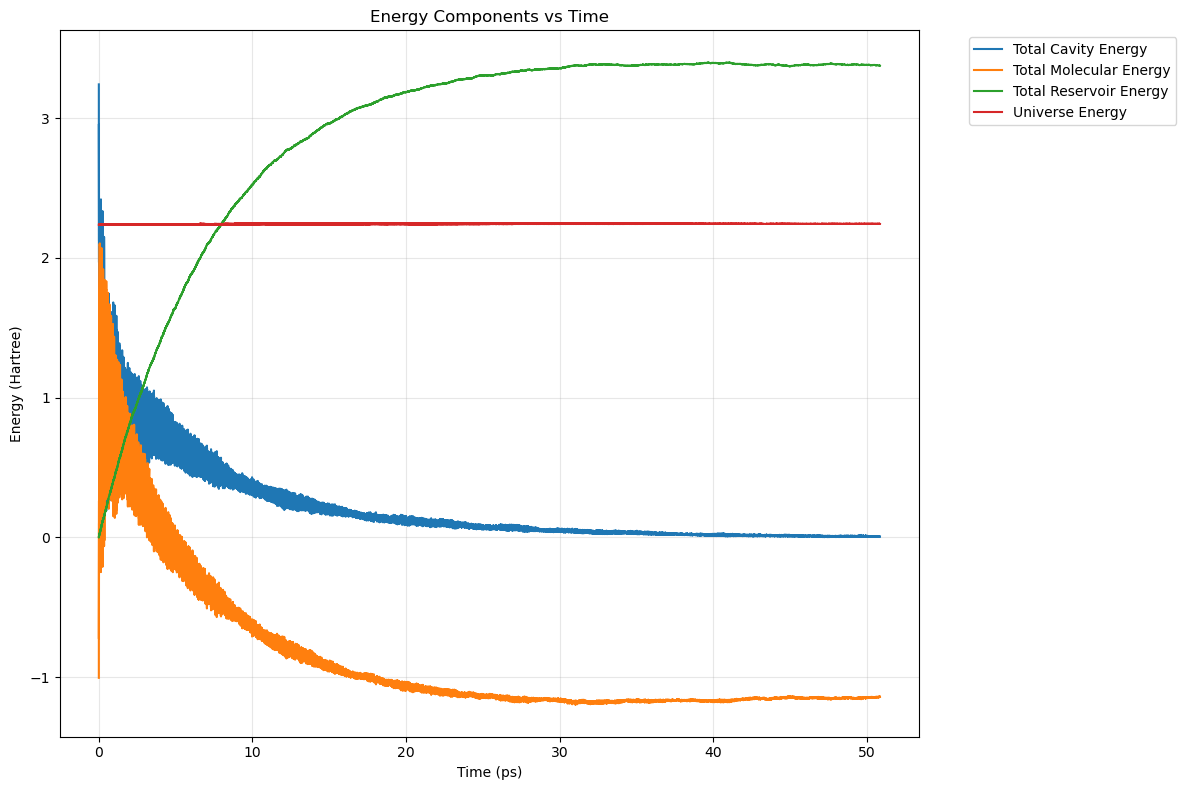


Energy Statistics:
Component                 Initial      Final        Drift        Std Dev     
---------------------------------------------------------------------------
Total Cavity Energy       3.241562     0.006613     -3.234949    0.482170    
Total Molecular Energy    -1.003797    -1.138866    -0.135069    0.862898    
Total Reservoir Energy    -0.000001    3.375515     3.375516     1.220013    
Universe Energy           2.237763     2.243263     0.005500     0.002619    

Energy Conservation Analysis:
Universe energy drift: 0.00550000 Hartree
Universe energy std dev: 0.00261948 Hartree
⚠ Energy conservation may need attention


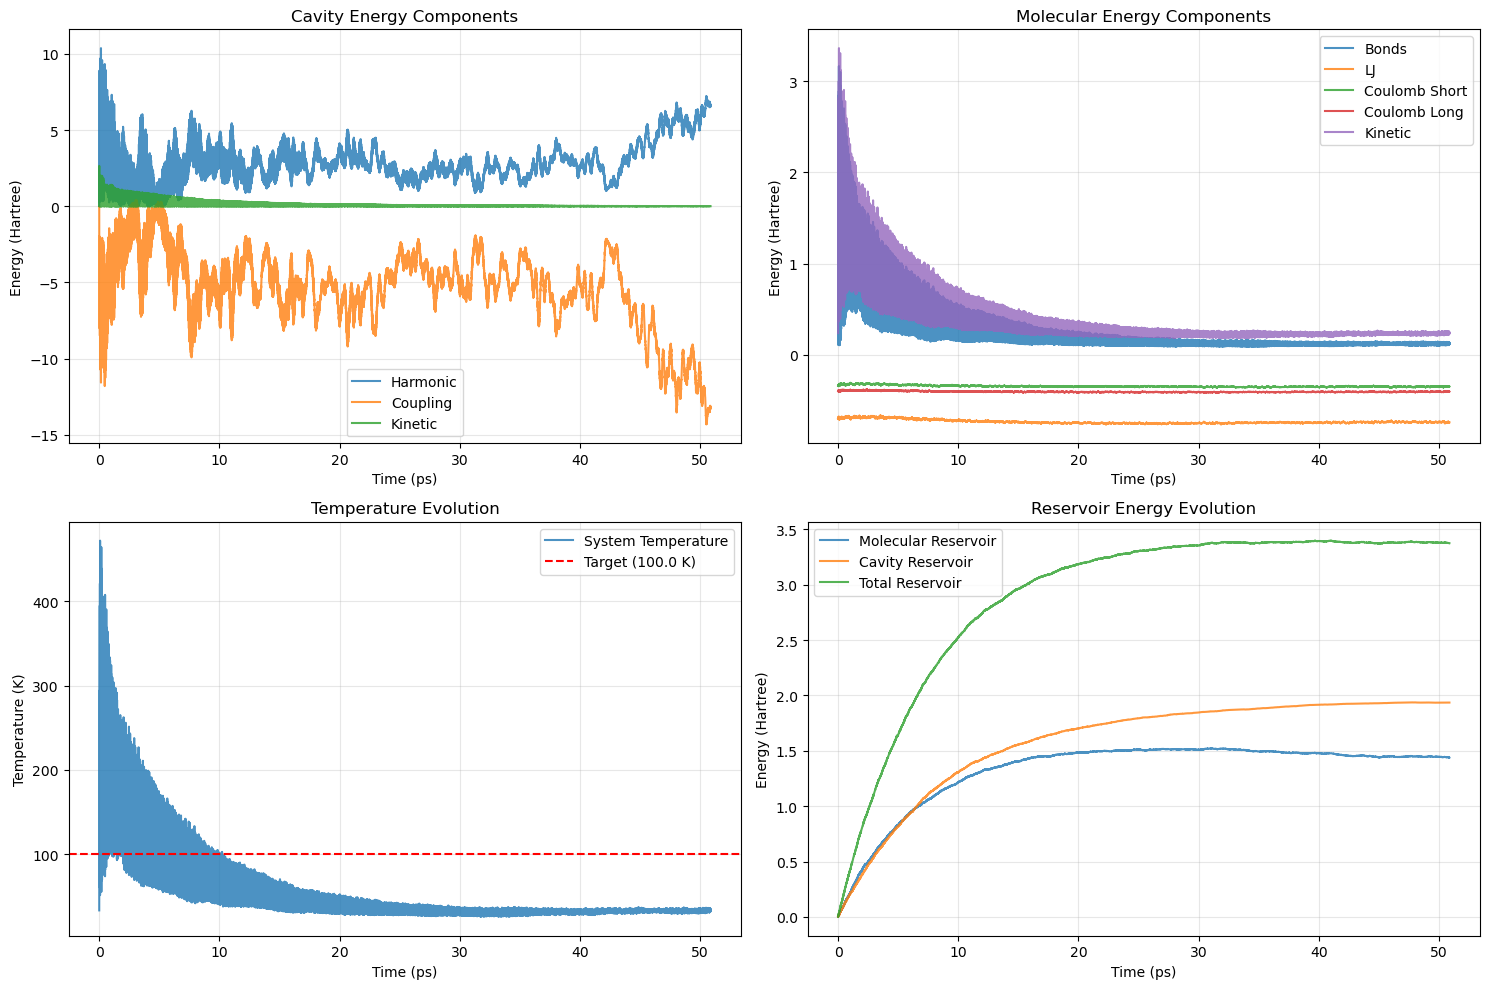


Temperature Statistics:
Target temperature: 100.0 K
Mean temperature: 90.28 K
Temperature std dev: 71.31 K
Temperature drift: 0.21 K


In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

if enable_energy_tracking:
    energy_file = f'{output_prefix}_energy_tracker.txt'
    
    if os.path.exists(energy_file):
        print(f"\nAnalyzing energy data from {energy_file}")
        
        try:
            # Read the energy data file
            # Skip the comment lines and read the data
            data = pd.read_csv(energy_file, sep='\s+', comment='#', skiprows=15)
            
            print(f"Loaded {len(data)} data points")
            print(f"Time range: {data['time(ps)'].min():.6f} - {data['time(ps)'].max():.6f} ps")
            
            # Extract time column
            time_ps = data['time(ps)']
            
            # Calculate energy components following the gnuplot command:
            # Total Cavity Energy: columns 10 + 12 (cavity_total_potential_energy + cavity_kinetic_energy)
            total_cavity_energy = data['cavity_total_potential_energy'] + data['cavity_kinetic_energy']
            
            # Total Molecular Energy: columns 3 + 4 + 5 + 6 + 11 
            # (harmonic_energy + lj_energy + ewald_short_energy + ewald_long_energy + molecular_kinetic_energy)
            total_molecular_energy = (data['harmonic_energy'] + data['lj_energy'] + 
                                    data['ewald_short_energy'] + data['ewald_long_energy'] + 
                                    data['molecular_kinetic_energy'])
            
            # Total Reservoir Energy: column 18
            total_reservoir_energy = data['total_reservoir_energy']
            
            # Universe Energy: column 19 (should be conserved)
            universe_energy = data['universe_total_energy']
            
            # Create the energy plot
            plt.figure(figsize=(12, 8))
            
            # Plot the energy components
            plt.plot(time_ps, total_cavity_energy, label='Total Cavity Energy', linewidth=1.5)
            plt.plot(time_ps, total_molecular_energy, label='Total Molecular Energy', linewidth=1.5)
            plt.plot(time_ps, total_reservoir_energy, label='Total Reservoir Energy', linewidth=1.5)
            plt.plot(time_ps, universe_energy, label='Universe Energy', linewidth=1.5)
            
            # Formatting
            plt.xlabel('Time (ps)')
            plt.ylabel('Energy (Hartree)')
            plt.title('Energy Components vs Time')
            plt.grid(True, alpha=0.3)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            
            # Show the plot
            plt.show()
            
            # Print energy statistics
            print(f"\nEnergy Statistics:")
            print(f"{'Component':<25} {'Initial':<12} {'Final':<12} {'Drift':<12} {'Std Dev':<12}")
            print("-" * 75)
            
            components = {
                'Total Cavity Energy': total_cavity_energy,
                'Total Molecular Energy': total_molecular_energy,
                'Total Reservoir Energy': total_reservoir_energy,
                'Universe Energy': universe_energy
            }
            
            for name, values in components.items():
                initial = values.iloc[0]
                final = values.iloc[-1]
                drift = final - initial
                std_dev = values.std()
                print(f"{name:<25} {initial:<12.6f} {final:<12.6f} {drift:<12.6f} {std_dev:<12.6f}")
            
            # Energy conservation check
            universe_drift = universe_energy.iloc[-1] - universe_energy.iloc[0]
            universe_std = universe_energy.std()
            print(f"\nEnergy Conservation Analysis:")
            print(f"Universe energy drift: {universe_drift:.8f} Hartree")
            print(f"Universe energy std dev: {universe_std:.8f} Hartree")
            
            if abs(universe_drift) < 1e-5 and universe_std < 1e-5:
                print("✓ Excellent energy conservation!")
            elif abs(universe_drift) < 1e-4 and universe_std < 1e-4:
                print("✓ Good energy conservation")
            else:
                print("⚠ Energy conservation may need attention")
            
            # Additional detailed plots
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            
            # Plot 1: Individual cavity energy components
            axes[0, 0].plot(time_ps, data['cavity_harmonic_energy'], label='Harmonic', alpha=0.8)
            axes[0, 0].plot(time_ps, data['cavity_coupling_energy'], label='Coupling', alpha=0.8)
            axes[0, 0].plot(time_ps, data['cavity_kinetic_energy'], label='Kinetic', alpha=0.8)
            axes[0, 0].set_xlabel('Time (ps)')
            axes[0, 0].set_ylabel('Energy (Hartree)')
            axes[0, 0].set_title('Cavity Energy Components')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)
            
            # Plot 2: Molecular energy components
            axes[0, 1].plot(time_ps, data['harmonic_energy'], label='Bonds', alpha=0.8)
            axes[0, 1].plot(time_ps, data['lj_energy'], label='LJ', alpha=0.8)
            axes[0, 1].plot(time_ps, data['ewald_short_energy'], label='Coulomb Short', alpha=0.8)
            axes[0, 1].plot(time_ps, data['ewald_long_energy'], label='Coulomb Long', alpha=0.8)
            axes[0, 1].plot(time_ps, data['molecular_kinetic_energy'], label='Kinetic', alpha=0.8)
            axes[0, 1].set_xlabel('Time (ps)')
            axes[0, 1].set_ylabel('Energy (Hartree)')
            axes[0, 1].set_title('Molecular Energy Components')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
            
            # Plot 3: Temperature evolution
            axes[1, 0].plot(time_ps, data['temperature'], label='System Temperature', alpha=0.8)
            axes[1, 0].axhline(y=temperature, color='red', linestyle='--', label=f'Target ({temperature} K)')
            axes[1, 0].set_xlabel('Time (ps)')
            axes[1, 0].set_ylabel('Temperature (K)')
            axes[1, 0].set_title('Temperature Evolution')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
            
            # Plot 4: Reservoir energies
            axes[1, 1].plot(time_ps, data['molecular_reservoir_energy'], label='Molecular Reservoir', alpha=0.8)
            axes[1, 1].plot(time_ps, data['cavity_reservoir_energy'], label='Cavity Reservoir', alpha=0.8)
            axes[1, 1].plot(time_ps, data['total_reservoir_energy'], label='Total Reservoir', alpha=0.8)
            axes[1, 1].set_xlabel('Time (ps)')
            axes[1, 1].set_ylabel('Energy (Hartree)')
            axes[1, 1].set_title('Reservoir Energy Evolution')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # Print temperature statistics
            temp_mean = data['temperature'].mean()
            temp_std = data['temperature'].std()
            print(f"\nTemperature Statistics:")
            print(f"Target temperature: {temperature:.1f} K")
            print(f"Mean temperature: {temp_mean:.2f} K")
            print(f"Temperature std dev: {temp_std:.2f} K")
            print(f"Temperature drift: {data['temperature'].iloc[-1] - data['temperature'].iloc[0]:.2f} K")
            
        except Exception as e:
            print(f"Error analyzing energy data: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"Energy file {energy_file} not found - skipping energy analysis")
else:
    print("Energy tracking was not enabled - skipping energy analysis")